<a href="https://colab.research.google.com/github/navneetslovely/QML_genom/blob/main/peg_QSVM_Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom

Mounted at /content/drive
/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom


In [3]:
!pip install qiskit-machine-learning
!pip install qiskit[visualization]
!pip install genomic-benchmarks
!pip install tensorflow>=2.6.0
!pip install tensorflow-addons
!pip install typing-extensions --upgrade
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 16.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512612 sha256=934603eca5567bcc85bd435e5ebda945dae763665a57937e57d3b8105e10031c
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448d

In [4]:
from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from functools import partial
# from qiskit import Aer
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.decomposition import PCA
algorithm_globals.random_seed = 42

In [5]:
# Load the preprocessed data
train_sequences = np.load('train_sequences.npy')
# print('train_sequences',train_sequences[:2])
train_labels = np.load('train_labels.npy')
# print('train_labels',train_labels[:2])
test_sequences = np.load('test_sequences.npy')
# print('test_sequences',test_sequences[:2])
test_labels = np.load('test_labels.npy')
# print('test_labels',test_labels[:2])
# Perform PCA transformation on the data
pca = PCA(n_components=4)
train_sequences = pca.fit_transform(train_sequences)
test_sequences= pca.fit_transform(test_sequences)

# Split the train_sequences, train_labels, test_sequences, and test_labels into 15 parts each
split_train_sequences = np.array_split(train_sequences, 15)
split_train_labels = np.array_split(train_labels, 15)
split_test_sequences = np.array_split(test_sequences, 15)
split_test_labels = np.array_split(test_labels, 15)

# Create directories to save the parts
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_sequences_parts', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_labels_parts', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_sequences_parts', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_labels_parts', exist_ok=True)

# Save each part into a separate file
for i in range(15):
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_sequences_parts/train_seq_{i+1}.npy', split_train_sequences[i])
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_labels_parts/train_labels_{i+1}.npy', split_train_labels[i])
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_sequences_parts/test_seq_{i+1}.npy', split_test_sequences[i])
    np.save(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/test_labels_parts/test_labels_{i+1}.npy', split_test_labels[i])

In [6]:
# Define the feature dimension or number of qubits
feature_dim = len(train_sequences[0])
print("Feature dimension and number of qubits:", feature_dim)
# number of steps performed during the training procedure
tau = 100
# regularization parameter
C = 1000

Feature dimension and number of qubits: 4


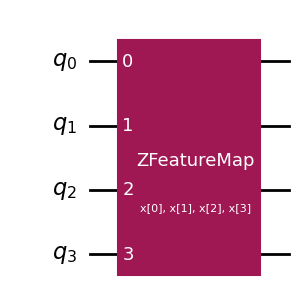

In [7]:
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(feature_dim, reps=2)
feature_map.draw('mpl')

In [10]:
qkernel = FidelityQuantumKernel(feature_map=feature_map)
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

In [11]:
num_epochs = 1  # Specify the number of epochs
batch_size = 1024  # Specify the batch size
total_time = 0

# Placeholder for saving scores
train_scores = []
test_scores = []

In [12]:
pegasos_qsvc.load("/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/Pegaos_QSVM_ZFeatureMap_epoch_5")

In [ ]:
num_epochs = 1  # Specify the number of epochs

# Loop over each epoch
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    epoch_train_scores = []  # Store training scores for each epoch

    # Loop over each data split
    for a in range(1, 5):
        # Load the split data
        train_sequences_part = np.load(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_sequences_parts/train_seq_{a}.npy')
        train_labels_part = np.load(f'/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/QML_genom_seq/train_labels_parts/train_labels_{a}.npy')

        print(f"Training on part {a} started")

        # Perform training for each batch
        for i in range(0, len(train_sequences_part), batch_size):
            batch_sequences = train_sequences_part[i:i+batch_size]
            batch_labels = train_labels_part[i:i+batch_size]

            # Fit the model on the batch
            pegasos_qsvc.fit(batch_sequences, batch_labels)


            print(f"Epoch {epoch + 3}, Part {a} - Batch {i // batch_size + 1} completed")



    # Calculate the time for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    total_time += epoch_time

    print(f"Epoch {epoch+3} - Time taken: {epoch_time:.2f} seconds")

print(f"Total training time: {total_time:.2f} seconds")


Training on part 1 started
Epoch 3, Part 1 - Batch 1 completed
Epoch 3, Part 1 - Batch 2 completed
Epoch 3, Part 1 - Batch 3 completed
Epoch 3, Part 1 - Batch 4 completed
Epoch 3, Part 1 - Batch 5 completed
Training on part 2 started
Epoch 3, Part 2 - Batch 1 completed
Epoch 3, Part 2 - Batch 2 completed
Epoch 3, Part 2 - Batch 3 completed
Epoch 3, Part 2 - Batch 4 completed
Epoch 3, Part 2 - Batch 5 completed
Training on part 3 started


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
predictions = pegasos_qsvc.predict(test_sequences[:4000])
true_labels = test_labels[:4000]

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision and Recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate F1-Score
f1 = f1_score(true_labels, predictions)
print(f"F1 Score: {f1:.4f}")

# Calculate ROC-AUC Score
# Since it's a binary classification, directly pass the true labels and predictions
roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate a full classification report
report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)